In [1]:
import numpy as np
from loadData import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import syft as sy
import copy
import matplotlib.pyplot as plt
from torch import nn, optim

In [2]:
"""""
Attributes:
    -denseOutputData
    -sparseOutputData
    -denseInputData
    -denseSampleIndex
    -sparseInputData
    -sparseSampleIndex
    -allSamples
    -folds
"""""
data = DataLoader(datasetName='static')

In [3]:
hook = sy.TorchHook(torch)
hook.local_worker.is_client_worker = False

server = hook.local_worker

In [4]:
data.denseOutputData = data.denseOutputData.astype('float64')

In [5]:
x = torch.tensor(data.denseInputData, dtype=torch.float32, requires_grad=True)
# i = torch.LongTensor([data.sparseOutputData.row,
#                           data.sparseOutputData.col])
# v = torch.FloatTensor(data.sparseOutputData.data)
# y = torch.sparse.FloatTensor(i, v, torch.Size(data.sparseOutputData.shape)).requires_grad_(True)
y = torch.tensor(data.denseOutputData, dtype=torch.float32, requires_grad=True)
in_dim  = x.size()[1]
out_dim = y.size()[1]

In [6]:
# print(data.sparseOutputData.shape)
print(y.size())
print(x.size())
#plt.scatter(np.arange(data.sparseOutputData.data.size), data.sparseOutputData.data)
#plt.show()

torch.Size([456331, 1310])
torch.Size([456331, 833])


In [7]:
nworkers = 10
workers = []
data_per_worker = int(x.size()[0] / nworkers)
# data_per_worker = 1
x_pointers = []
y_pointers = []

#itt definiálom a workereket
print("Creating workers...")
secure_worker = sy.VirtualWorker(hook, id="secure_worker")
for i in range(nworkers):
    print("Worker id:", 'w'+str(i), "has data from:",(i) * data_per_worker, "to", (i+1) * data_per_worker)
      
    #tenzorok másolása workereknek
#     xi = x[i * data_per_worker: (i+1) * data_per_worker].clone().detach().requires_grad_(True).tag('input_data')
#     yi = y[i * data_per_worker: (i+1) * data_per_worker].clone().detach().requires_grad_(True).tag('output_data')
#     xi = torch.tensor(data.denseInputData[i * data_per_worker: (i+1) * data_per_worker], dtype=torch.float32, requires_grad=True).tag('input_data')
#     yi = torch.tensor(data.denseOutputData[i * data_per_worker: (i+1) * data_per_worker], dtype=torch.float32, requires_grad=True).tag('output_data')
    
    xi = x[i * data_per_worker: (i+1) * data_per_worker].tag('input_data')
    yi = y[i * data_per_worker: (i+1) * data_per_worker].tag('output_data')
#     workers.append(sy.VirtualWorker(hook, id='w'+str(i), data=(xi, yi)))
    workers.append(sy.VirtualWorker(hook, id='w'+str(i)))
    
    x_pointers.append(xi.send(workers[i]))
    y_pointers.append(yi.send(workers[i]))
    
#     x_pointers.append(workers[i].search('input_data')[0])
#     y_pointers.append(workers[i].search('output_data')[0])

Creating workers...
Worker id: w0 has data from: 0 to 45633
Worker id: w1 has data from: 45633 to 91266
Worker id: w2 has data from: 91266 to 136899
Worker id: w3 has data from: 136899 to 182532
Worker id: w4 has data from: 182532 to 228165
Worker id: w5 has data from: 228165 to 273798
Worker id: w6 has data from: 273798 to 319431
Worker id: w7 has data from: 319431 to 365064
Worker id: w8 has data from: 365064 to 410697
Worker id: w9 has data from: 410697 to 456330


Innen kell újra csak

In [14]:
latent_dim = 1000
class TrunkNet(nn.Module):
    def __init__(self):
        super(TrunkNet, self).__init__()
        self.layer1 = nn.Linear(in_features=in_dim, out_features=latent_dim)
        self.weight = self.layer1.weight
        self.bias = self.layer1.bias

    def forward(self, x):
        return F.sigmoid(self.layer1(x))

In [15]:
class HeadNet(nn.Module):
    def __init__(self):
        super(HeadNet, self).__init__()
        self.layer1 = nn.Linear(in_features=latent_dim, out_features=out_dim)
        self.weight = self.layer1.weight
        self.bias = self.layer1.bias

    def forward(self, x):
        return self.layer1(x)

In [16]:
learningRate = 0.1

#ezt még használom később
trunkNet = TrunkNet()
# trunkNet.build(torch.zeros(in_dim))
#ezt már nem
headNetInit = HeadNet()
# headNetInit.build(torch.zeros(latent_dim))

head_pointers = []
optimizer_pointers = []

print("Sending head networks")
for i in range(nworkers):
    print("Sending model:",i)
    head_pointers.append(headNetInit.copy().send(workers[i]))
print("Models sent")

Sending head networks
Sending model: 0
Sending model: 1
Sending model: 2
Sending model: 3
Sending model: 4
Sending model: 5
Sending model: 6
Sending model: 7
Sending model: 8
Sending model: 9
Models sent


In [17]:
# @sy.func2plan(args_shape=[(data_per_worker, out_dim),(data_per_worker, out_dim)])
# def plan_MSE(preds, expected):
#     return ((preds - expected) **2).sum() / data_per_worker
# plan_MSE.is_built

In [18]:
loss_history = []
def train(epochs, worker_iters):
    for epoch in range(1, epochs+1):
        
        print("Epoch", epoch)
        print(" Sending models...")
        
        trunk_pointers = []
        optimizer_pointers = []
        head_optimizer_pointers = []
        for i in range(nworkers):
            trunk_pointers.append(trunkNet.copy().send(workers[i]))
            optimizer_pointers.append(optim.SGD([
                {'params': trunk_pointers[i].parameters()},
                {'params': head_pointers[i].parameters(), 'lr': 0.001}
            ],lr=learningRate))
#             params = list(trunk_pointers[i].parameters()) + list(head_pointers[i].parameters()) 
#             optimizer_pointers.append(optim.SGD(params=params ,lr=learningRate))


        losses = []
        for wi in range(worker_iters):
            preds = []
            losses = []

            print(" Worker iterations", wi)
            for i in range(nworkers):
                print("  Worker", i, end =" ")
                
                optimizer_pointers[i].zero_grad()
                preds.append(head_pointers[i](trunk_pointers[i](x_pointers[i])))
                losses.append(((preds[i] - y_pointers[i]) **2).sum() /data_per_worker)
                losses[i].backward()
                
                optimizer_pointers[i].step()
                
                ##############################################################
#                 head_optimizer_pointers[i].zero_grad()
#                 preds[i] = head_pointers[i](trunk_pointers[i](x_pointers[i]))
#                 losses[i] = ((preds[i] - y_pointers[i]) **2).sum() /data_per_worker
#                 losses[i].backward()
                
#                 head_optimizer_pointers[i].step()
                #############################################################
                
                losses[i] = losses[i].get().data
                
            print("")
        
        print(" Sending back models...")
        for i in range(nworkers):
            trunk_pointers[i].move(secure_worker)
                
        print(" Averaging weights")
        with torch.no_grad():
            sumw = 0
            sumb = 0
            for i in range(nworkers):
                sumw += trunk_pointers[i].weight.data
                sumb += trunk_pointers[i].bias.data
                
            trunkNet.weight.set_((sumw / nworkers).get())
            trunkNet.bias.set_((sumb / nworkers).get())

        sumloss = 0
        for i in range(nworkers):
            sumloss += losses[i]
            
        loss_history.append((sumloss/nworkers).item)
        print("Average loss:", sumloss/nworkers)

In [19]:
train(100,1)

Epoch 1
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(203.9473)
Epoch 2
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(126.0466)
Epoch 3
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(68.2741)
Epoch 4
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(38.0587)
Epoch 5
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1 

  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(9.6741)
Epoch 37
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(9.6323)
Epoch 38
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(9.5923)
Epoch 39
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(9.5538)
Epoch 40
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Work

  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(8.8655)
Epoch 72
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(8.8536)
Epoch 73
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(8.8420)
Epoch 74
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Worker 6   Worker 7   Worker 8   Worker 9 
 Sending back models...
 Averaging weights
Average loss: tensor(8.8309)
Epoch 75
 Sending models...
 Worker iterations 0
  Worker 0   Worker 1   Worker 2   Worker 3   Worker 4   Worker 5   Work

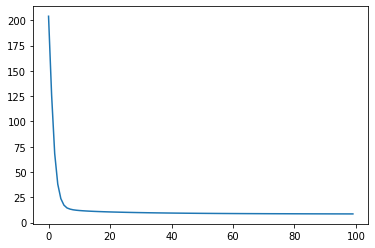

In [33]:
plt.plot(loss_history)